# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [3]:
!pip install unrar

In [5]:
import os
os.chdir("/content/drive/MyDrive/ACV")
!ls

images_racoon-1.rar			    train_labels.csv
R10_Internal_Lab_Question_Notebook-1.ipynb


In [9]:
!pip install patool
import patoolib

patoolib.extract_archive("images_racoon-1.rar")




patool: Extracting images_racoon-1.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/ACV/images_racoon-1.rar"
patool:     with cwd='./Unpack_x_e4w__b'
patool: ... images_racoon-1.rar extracted to `images'.


'images'

### Import the necessary libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [20]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input

### Mount to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Change directory

In [ ]:
import os
os.chdir("/content/drive/MyDrive/ACV")
!ls

### Load the training data from train.csv file

In [11]:
train = pd.read_csv("train_labels.csv")
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [12]:
train.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [13]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width and height, x0, y0, x1, y1 in individual variables. <br>
1. Create a list variable known as 'paths' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be resized to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [14]:
coords =np.zeros((len(train),4))
coords.shape

(173, 4)

In [17]:
paths = []
coords = np.zeros((len(train), 4))

coords = np.zeros((len(train), 4))
for index, row in train.iterrows():
  filename = row['filename']
  #paths.append(os.getcwd() + "/" + "images" +"/" + filename )
  paths.append(os.path.join(os.getcwd(),"images" , filename ))
  coords[index][0] = int(row['xmin'] * IMAGE_SIZE / row['width'])
  coords[index][1] = int(row['ymin'] * IMAGE_SIZE / row['height'])
  coords[index][2] = int(row['xmax'] * IMAGE_SIZE / row['width'])
  coords[index][3] = int(row['ymax'] * IMAGE_SIZE / row['height'])

  
  
print(paths)


['/content/drive/My Drive/ACV/images/raccoon-17.jpg', '/content/drive/My Drive/ACV/images/raccoon-11.jpg', '/content/drive/My Drive/ACV/images/raccoon-63.jpg', '/content/drive/My Drive/ACV/images/raccoon-63.jpg', '/content/drive/My Drive/ACV/images/raccoon-60.jpg', '/content/drive/My Drive/ACV/images/raccoon-69.jpg', '/content/drive/My Drive/ACV/images/raccoon-180.jpg', '/content/drive/My Drive/ACV/images/raccoon-200.jpg', '/content/drive/My Drive/ACV/images/raccoon-141.jpg', '/content/drive/My Drive/ACV/images/raccoon-19.jpg', '/content/drive/My Drive/ACV/images/raccoon-84.jpg', '/content/drive/My Drive/ACV/images/raccoon-124.jpg', '/content/drive/My Drive/ACV/images/raccoon-182.jpg', '/content/drive/My Drive/ACV/images/raccoon-111.jpg', '/content/drive/My Drive/ACV/images/raccoon-91.jpg', '/content/drive/My Drive/ACV/images/raccoon-79.jpg', '/content/drive/My Drive/ACV/images/raccoon-93.jpg', '/content/drive/My Drive/ACV/images/raccoon-20.jpg', '/content/drive/My Drive/ACV/images/rac

In [19]:
coords[100]

array([ 13.,  29.,  71., 126.])

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [ ]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3))
for i , image in enumerate(paths):
  img = Image.open(image)
  ## Resize 
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  ## Convert to RGB
  img = img.convert('RGB')
  ## preprocess_input for mobilenet
  batch_images[i] = preprocess_input(np.array(img))


In [26]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3.
### Freeze all the layers and Add convolution layers and reshape layers at the end to ensure the output has 4 coordinates.

In [27]:
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

alpha: Controls the width of the network. This is known as the width multiplier in the MobileNet paper. - If alpha < 1.0, proportionally decreases the number of filters in each layer. - If alpha > 1.0, proportionally increases the number of filters in each layer. - If alpha = 1, default number of filters from the paper are used at each layer. Default to 1.0.


In [32]:
model = MobileNet(input_shape = (IMAGE_SIZE,IMAGE_SIZE, 3) , include_top = False)

17227776/17225924 [==============================] - 0s 0us/step


In [33]:
##Freeze layers
for layer in model.layers:
  layer.trainable = False

x = model.layers[-1].output
x = Conv2D(4,kernel_size=4)(x)

##Reshape 4 Coordinates

x = Reshape((4,))(x)

In [36]:
model = Model(inputs = model.input , outputs = x)

## Plot the model and view the whole skeleton using plot_model.

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0     

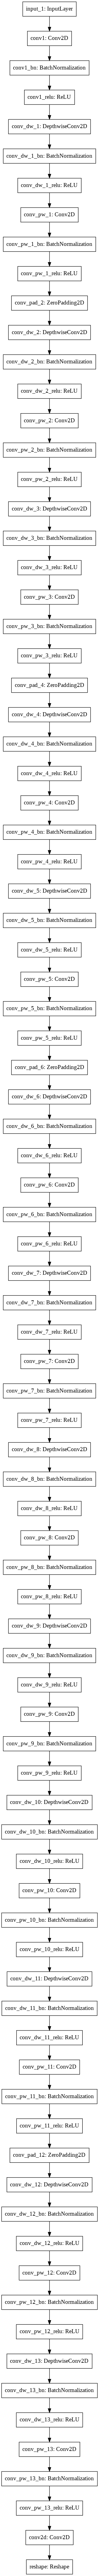

In [38]:
tf.keras.utils.plot_model(model=model)


### Define a custom loss function IoU which calculates Intersection Over Union

In [43]:
import tensorflow 
from tensorflow.keras.backend import epsilon
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tensorflow.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [44]:
model.compile(optimizer='adam',loss='mse',metrics=[IoU])
model.fit(batch_images,coords,epochs=30,batch_size=32,verbose=1)


Epoch 1/30
6/6 [==============================] - 4s 356ms/step - loss: 3980.3977 - IoU: 0.0785
Epoch 2/30
6/6 [==============================] - 2s 358ms/step - loss: 746.6897 - IoU: 0.4337
Epoch 3/30
6/6 [==============================] - 2s 357ms/step - loss: 460.0389 - IoU: 0.5736
Epoch 4/30
6/6 [==============================] - 2s 350ms/step - loss: 604.7141 - IoU: 0.5334
Epoch 5/30
6/6 [==============================] - 2s 355ms/step - loss: 339.6372 - IoU: 0.6230
Epoch 6/30
6/6 [==============================] - 2s 362ms/step - loss: 182.9095 - IoU: 0.6612
Epoch 7/30
6/6 [==============================] - 2s 359ms/step - loss: 194.7600 - IoU: 0.6566
Epoch 8/30
6/6 [==============================] - 2s 349ms/step - loss: 160.1503 - IoU: 0.7088
Epoch 9/30
6/6 [==============================] - 2s 349ms/step - loss: 123.1855 - IoU: 0.7370
Epoch 10/30
6/6 [==============================] - 2s 353ms/step - loss: 114.8685 - IoU: 0.7625
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

In [45]:
filename = 'images/raccoon-10.jpg'

#test_image = cv2.imread(filename)
img = Image.open(filename)
  ## Resize 
test_img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  ## Convert to RGB
test_img = test_img.convert('RGB')
  ## preprocess_input for mobilenet
test_img = preprocess_input(np.array(test_img))



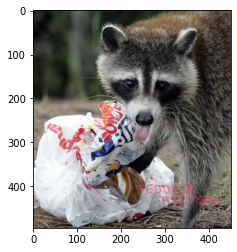

In [46]:
plt.imshow(img)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

### Predict the coordinates of the bounding box for the given test image

In [56]:
region = model.predict(np.expand_dims(test_img , axis = 0))[0]


In [57]:
region

array([ 36.173634 ,  -1.8387599, 126.74821  , 122.85426  ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [59]:
unscaled = img

In [60]:
image_width = img.size[0]
image_height = img.size[1]

In [58]:
import matplotlib.patches as patches


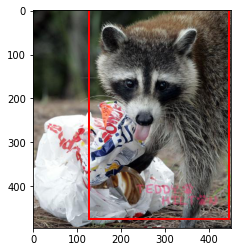

In [61]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# VGG16 Implementation

# VGG 16 Implementation
### Define a variable Image_size which takes accurate input according to the VGG16 model. 

In [64]:
IMAGE_SIZE = 224

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 224 * 224 

In [65]:
paths = []
coords = np.zeros((len(train), 4))

coords = np.zeros((len(train), 4))
for index, row in train.iterrows():
  filename = row['filename']
  #paths.append(os.getcwd() + "/" + "images" +"/" + filename )
  paths.append(os.path.join(os.getcwd(),"images" , filename ))
  coords[index][0] = int(row['xmin'] * IMAGE_SIZE / row['width'])
  coords[index][1] = int(row['ymin'] * IMAGE_SIZE / row['height'])
  coords[index][2] = int(row['xmax'] * IMAGE_SIZE / row['width'])
  coords[index][3] = int(row['ymax'] * IMAGE_SIZE / row['height'])

  
  
print(paths)


['/content/drive/My Drive/ACV/images/raccoon-17.jpg', '/content/drive/My Drive/ACV/images/raccoon-11.jpg', '/content/drive/My Drive/ACV/images/raccoon-63.jpg', '/content/drive/My Drive/ACV/images/raccoon-63.jpg', '/content/drive/My Drive/ACV/images/raccoon-60.jpg', '/content/drive/My Drive/ACV/images/raccoon-69.jpg', '/content/drive/My Drive/ACV/images/raccoon-180.jpg', '/content/drive/My Drive/ACV/images/raccoon-200.jpg', '/content/drive/My Drive/ACV/images/raccoon-141.jpg', '/content/drive/My Drive/ACV/images/raccoon-19.jpg', '/content/drive/My Drive/ACV/images/raccoon-84.jpg', '/content/drive/My Drive/ACV/images/raccoon-124.jpg', '/content/drive/My Drive/ACV/images/raccoon-182.jpg', '/content/drive/My Drive/ACV/images/raccoon-111.jpg', '/content/drive/My Drive/ACV/images/raccoon-91.jpg', '/content/drive/My Drive/ACV/images/raccoon-79.jpg', '/content/drive/My Drive/ACV/images/raccoon-93.jpg', '/content/drive/My Drive/ACV/images/raccoon-20.jpg', '/content/drive/My Drive/ACV/images/rac

In [66]:
coords[0]

array([ 82.,  69., 144., 136.])

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the VGG16 accepts 3 channels as inputs   

In [67]:
from tensorflow.keras.applications.vgg16 import preprocess_input
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3))
for i , image in enumerate(paths):
  img = Image.open(image)
  ## Resize 
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  ## Convert to RGB
  img = img.convert('RGB')
  ## preprocess_input for mobilenet
  batch_images[i] = preprocess_input(np.array(img))

In [68]:
batch_images[0]

array([[[ -28.93900299,  -29.77899933,  -59.68000031],
        [  -7.93900299,   -9.77899933,  -37.68000031],
        [ -90.93900299,  -91.77899933, -117.68000031],
        ...,
        [  41.06099701,   62.22100067,    1.31999969],
        [  82.06099701,  101.22100067,   42.31999969],
        [  75.06099701,  100.22100067,   41.31999969]],

       [[  -7.93900299,   -8.77899933,  -37.68000031],
        [ -24.93900299,  -26.77899933,  -53.68000031],
        [-101.93900299, -108.77899933, -122.68000031],
        ...,
        [  50.06099701,   72.22100067,   14.31999969],
        [  67.06099701,   85.22100067,   31.31999969],
        [  60.06099701,   80.22100067,   25.31999969]],

       [[   1.06099701,   -0.77899933,  -28.68000031],
        [ -46.93900299,  -49.77899933,  -73.68000031],
        [-103.93900299, -114.77899933, -123.68000031],
        ...,
        [  31.06099701,   58.22100067,    1.31999969],
        [  48.06099701,   65.22100067,   13.31999969],
        [  56.06099701

### Define a vgg16 model and plot the model using plot_model function.
Hint:- Use RepeatVector,Conv1D,GlobalAveragePooling2D(optional to learner)

In [71]:
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape,Flatten
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

vgg_model = VGG16(input_shape = (IMAGE_SIZE,IMAGE_SIZE, 3) , include_top = False)

##Freeze layers
for layer in vgg_model.layers:
  layer.trainable = False

x = vgg_model.layers[-1].output
x = Conv2D(4,kernel_size=7)(x)

##Flatten 4 Coordinates

x = Flatten()(x)

vgg_model = Model(inputs = vgg_model.input , outputs = x)

### Plot the Vgg16 model using plot_model function.

In [72]:
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

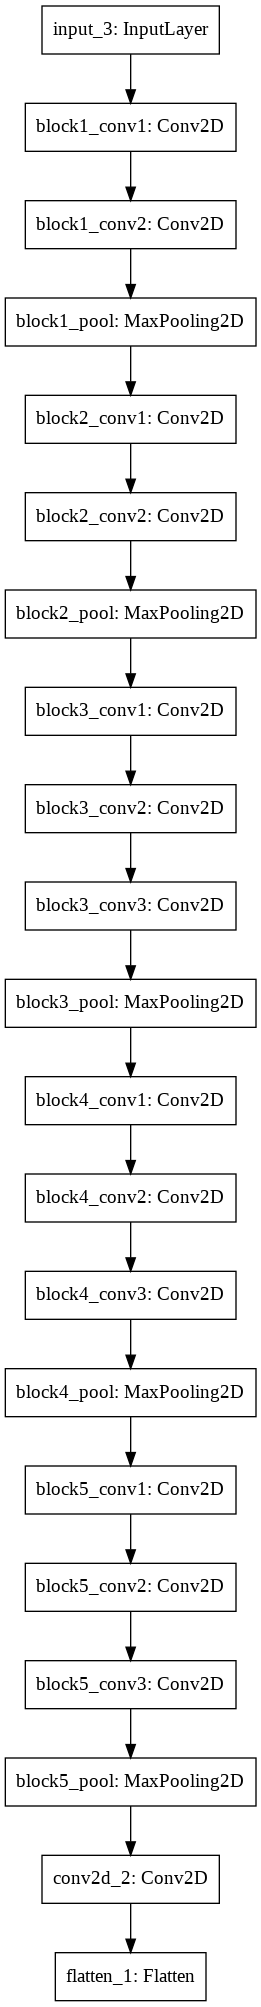

In [73]:
tf.keras.utils.plot_model(model=vgg_model)

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [74]:
vgg_model.compile(optimizer='adam',loss='mse',metrics=[IoU])
vgg_model.fit(batch_images,coords,epochs=30,batch_size=32,verbose=1)

Epoch 1/30
6/6 [==============================] - 86s 14s/step - loss: 7955.6494 - IoU: 0.2722
Epoch 2/30
6/6 [==============================] - 84s 14s/step - loss: 3946.2898 - IoU: 0.4276
Epoch 3/30
6/6 [==============================] - 84s 14s/step - loss: 2499.0327 - IoU: 0.3899
Epoch 4/30
6/6 [==============================] - 85s 14s/step - loss: 1139.5737 - IoU: 0.5480
Epoch 5/30
6/6 [==============================] - 84s 14s/step - loss: 1077.3862 - IoU: 0.5872
Epoch 6/30
6/6 [==============================] - 84s 14s/step - loss: 653.0857 - IoU: 0.6657
Epoch 7/30
6/6 [==============================] - 84s 14s/step - loss: 488.7798 - IoU: 0.6868
Epoch 8/30
6/6 [==============================] - 84s 14s/step - loss: 410.4486 - IoU: 0.6896
Epoch 9/30
6/6 [==============================] - 84s 14s/step - loss: 321.7511 - IoU: 0.7178
Epoch 10/30
6/6 [==============================] - 84s 14s/step - loss: 311.5093 - IoU: 0.7568
Epoch 11/30
6/6 [==============================] - 84s

### Pick a test image from the given data

In [75]:
filename = 'images/raccoon-10.jpg'

#test_image = cv2.imread(filename)
img = Image.open(filename)
  ## Resize 
test_img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  ## Convert to RGB
test_img = test_img.convert('RGB')
  ## preprocess_input for mobilenet
test_img = preprocess_input(np.array(test_img))


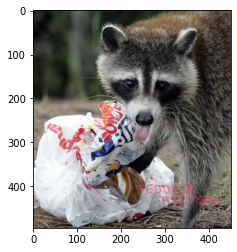

In [76]:
plt.imshow(img)

### Resize the image to 224 * 224 and preprocess the image for the VGG16

### Predict the coordinates of the bounding box for the given test image

In [77]:
region = vgg_model.predict(np.expand_dims(test_img , axis = 0))[0]

In [78]:
region

array([121.92983 ,  -6.605127, 225.5748  , 220.56432 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [80]:
unscaled = img
image_width = img.size[0]
image_height = img.size[1]

In [81]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


### Visualizing model details in tensorboard

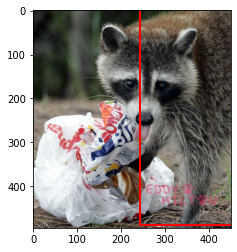

In [82]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()